In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [2]:
df = pd.read_csv('train.csv', delimiter=';')
df.drop(columns=['month', 'day', 'y', 'previous', 'poutcome', 'campaign', 'pdays', 'duration'], inplace=True)
print(df.info()) 
print(df.describe())
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
dtypes: int64(2), object(7)
memory usage: 3.1+ MB
None
                age        balance
count  45211.000000   45211.000000
mean      40.936210    1362.272058
std       10.618762    3044.765829
min       18.000000   -8019.000000
25%       33.000000      72.000000
50%       39.000000     448.000000
75%       48.000000    1428.000000
max       95.000000  102127.000000


age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
dtype: int64

In [3]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact
0,58,management,married,tertiary,no,2143,yes,no,unknown
1,44,technician,single,secondary,no,29,yes,no,unknown
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown
4,33,unknown,single,unknown,no,1,no,no,unknown


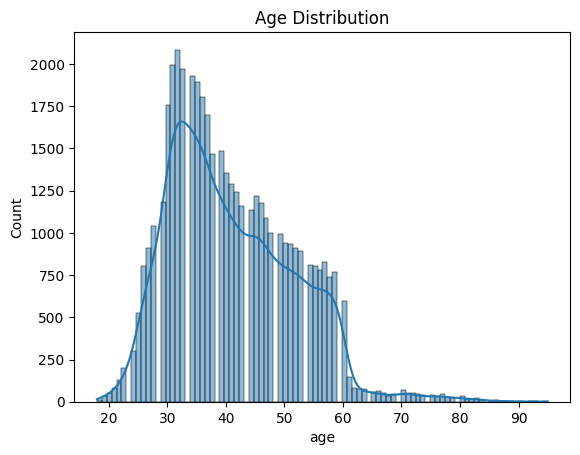

In [4]:
sns.histplot(df['age'], kde=True)
plt.title('Age Distribution')
plt.show()

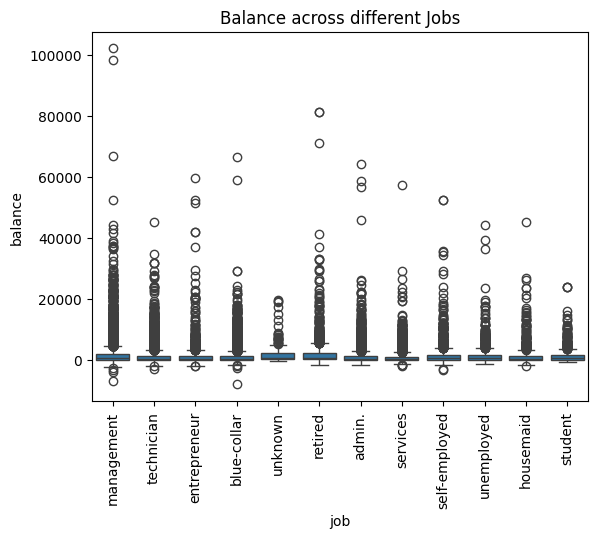

In [5]:
sns.boxplot(x='job', y='balance', data=df)
plt.title('Balance across different Jobs')
plt.xticks(rotation=90)
plt.show()

In [6]:
categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact']
numerical_cols = ['age', 'balance']

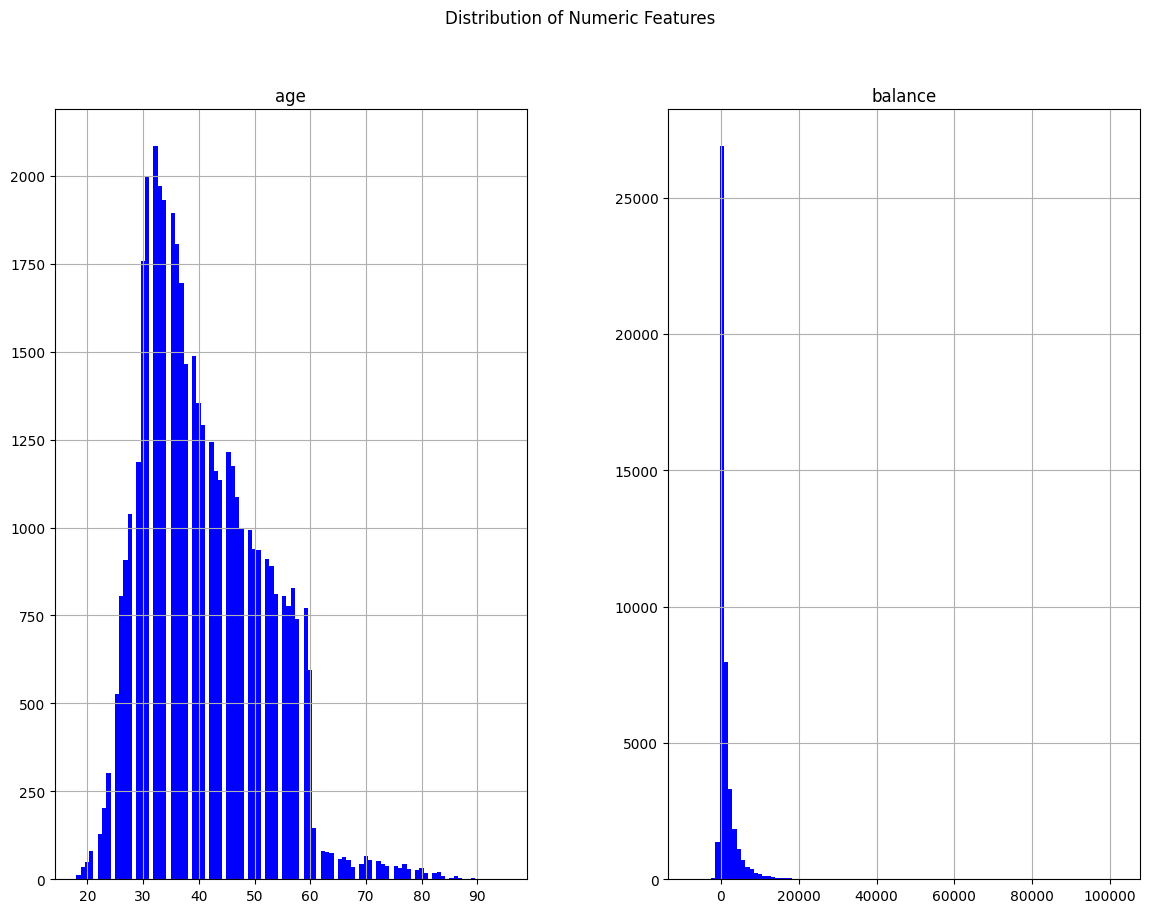

In [7]:
df[numerical_cols].hist(bins=100, figsize=(14, 10), color='blue')
plt.suptitle('Distribution of Numeric Features')
plt.show()

In [8]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ])

In [9]:
X = preprocessor.fit_transform(df)

In [10]:
X

array([[ 1.60696496,  0.25641925,  0.        , ...,  0.        ,
         0.        ,  1.        ],
       [ 0.28852927, -0.43789469,  0.        , ...,  0.        ,
         0.        ,  1.        ],
       [-0.74738448, -0.44676247,  0.        , ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 2.92540065,  1.42959305,  0.        , ...,  1.        ,
         0.        ,  0.        ],
       [ 1.51279098, -0.22802402,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       [-0.37068857,  0.52836436,  0.        , ...,  1.        ,
         0.        ,  0.        ]])

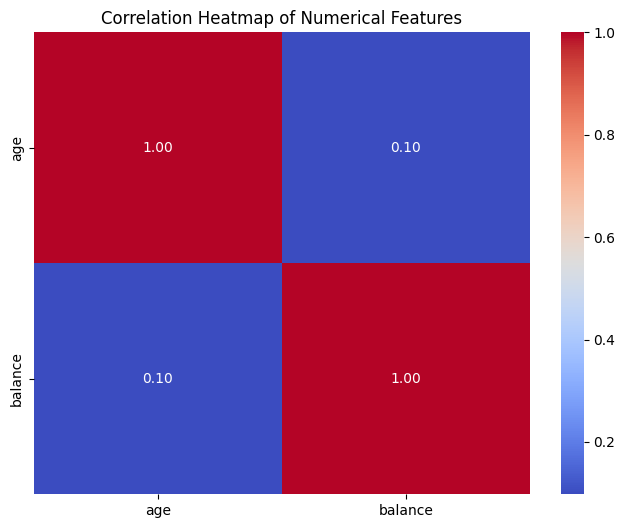

In [11]:
corr_matrix = df[numerical_cols].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

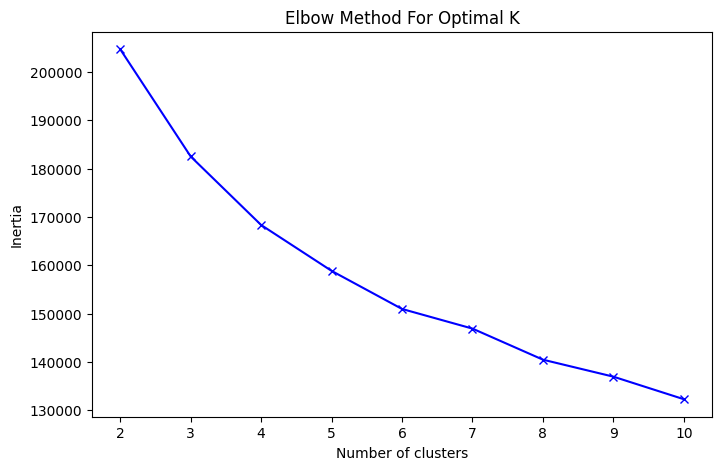

In [12]:
inertia = []
K = range(2, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal K')
plt.show()


In [19]:
optimal_clusters = 3
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
clusters = kmeans.fit_predict(X)

In [20]:
df['cluster'] = clusters

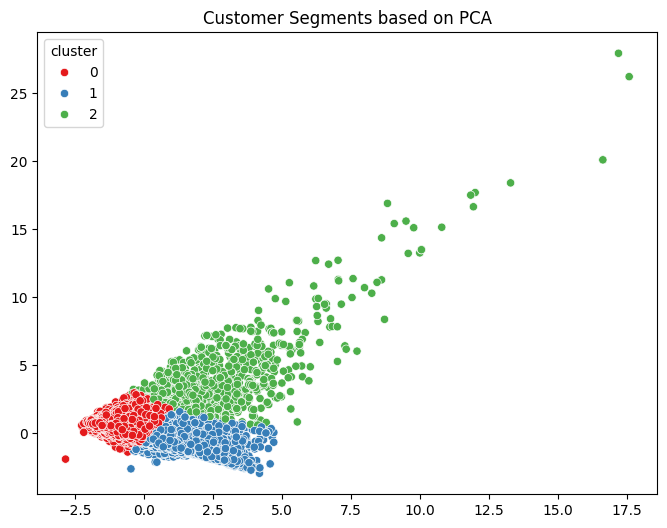

In [21]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['cluster'], palette='Set1')
plt.title('Customer Segments based on PCA')
plt.show()


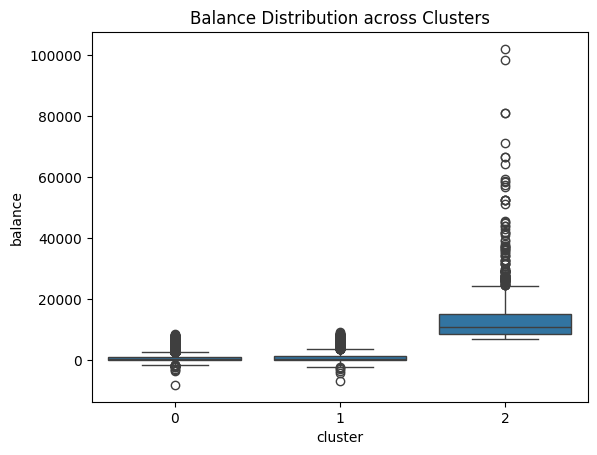

In [22]:
sns.boxplot(x='cluster', y='balance', data=df)
plt.title('Balance Distribution across Clusters')
plt.show()

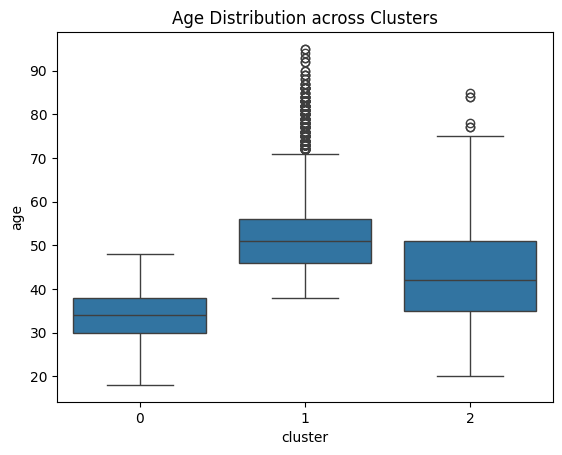

In [23]:
sns.boxplot(x='cluster', y='age', data=df)
plt.title('Age Distribution across Clusters')
plt.show()

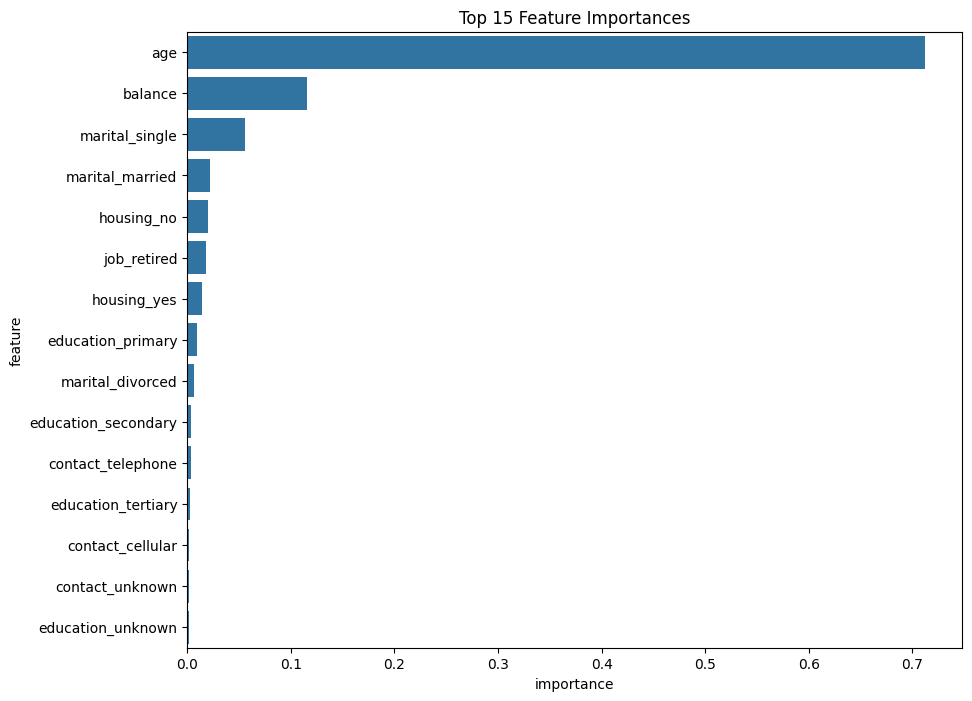

In [24]:
from sklearn.ensemble import RandomForestClassifier
rf_df = df.copy()
rf_df = pd.get_dummies(rf_df, columns=categorical_cols)

# Random Forest Model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(rf_df.drop(columns='cluster'), rf_df['cluster'])

importances = rf.feature_importances_

encoded_feature_names = np.hstack([
    numerical_cols,
    preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
])

feature_importance_df = pd.DataFrame({
    'feature': encoded_feature_names,
    'importance': importances
})

feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(15))  # Top 15 features
plt.title('Top 15 Feature Importances')
plt.show()